In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras


## Imports and Initial Configurations

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from cv2 import imread, resize
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import keras
from keras import backend as K



# Directory & Paths

In [ ]:
img_directory = "/content/drive/MyDrive/Final Project/project-data/Lung Segmentation/CXR_png"
mask_directory = "/content/drive/MyDrive/Final Project/project-data/Lung Segmentation/masks/"

#Utility Functions

In [ ]:
# Dice Coefficient and Loss
def dice_coefficient(y_true, y_pred):
    y_true_flattened = K.flatten(y_true)
    y_pred_flattened = K.flatten(y_pred)
    intersection = K.sum(y_true_flattened * y_pred_flattened)


    return (2. * intersection + 1) / (keras.backend.sum(y_true_flattened) + keras.backend.sum(y_pred_flattened) + 1)


def dice_coefficient_loss(y_true, y_pred):
    return -dice_coefficient(y_true, y_pred)

# Data Loading Function
def preprocess_data(dim_size, category="test"):
    image_list = []
    mask_list = []
    filenames = test_names if category == "test" else train_names

    for filename in tqdm(filenames):
        img_name = filename if category == "test" else filename.split("_mask")[0] + ".png"
        mask_name = filename if category == "test" else filename + ".png"
        img = resize(imread(os.path.join(img_directory, img_name)), (dim_size, dim_size))[:, :, 0]
        mask = resize(imread(os.path.join(mask_directory, mask_name)), (dim_size, dim_size))[:, :, 0]
        image_list.append(img)
        mask_list.append(mask)

    return image_list, mask_list

# Function to Display Images
def display_data(X, Y):
    for index in range(6):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(X[index], cmap='gray')
        axes[0].set_title('Image')
        axes[1].imshow(Y[index], cmap='gray')
        axes[1].set_title('Mask')
        plt.show()


# Data Prep

In [ ]:
img_names = os.listdir(img_directory)
mask_names = [name.split(".png")[0] for name in os.listdir(mask_directory)]
img_file_names = [name.split("_mask")[0] for name in mask_names]


In [ ]:
# Separate test and train filenames
test_names = set(os.listdir(img_directory)) & set(os.listdir(mask_directory))
train_names = [name for name in mask_names if "mask" in name]



In [ ]:
# Load and preprocess data
train_data, train_masks = preprocess_data(512, category="train")
test_data, test_masks = preprocess_data(512, category="test")

100%|██████████| 138/138 [02:42<00:00,  1.17s/it]


Training Data Samples


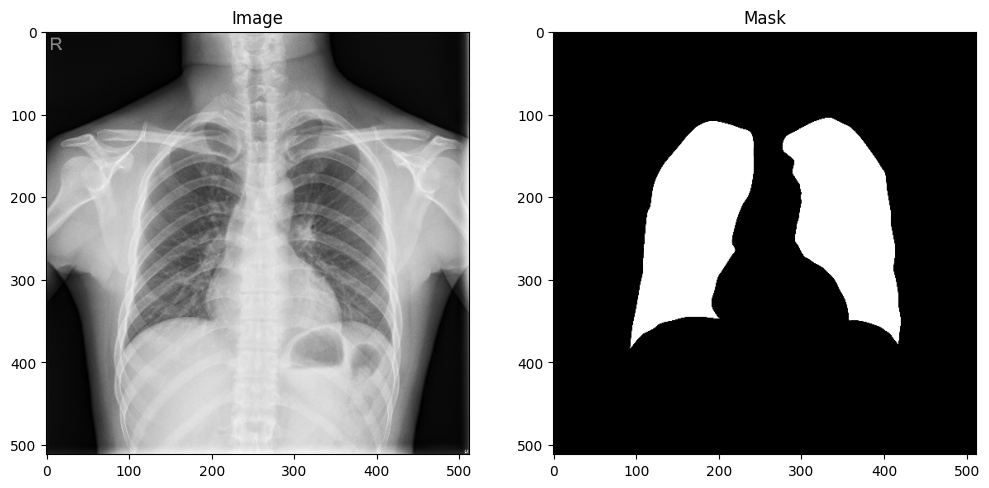

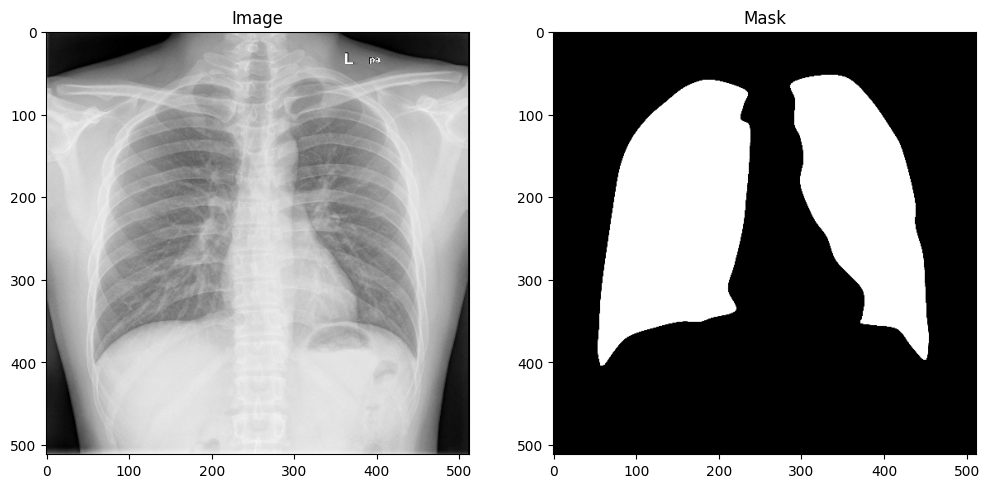

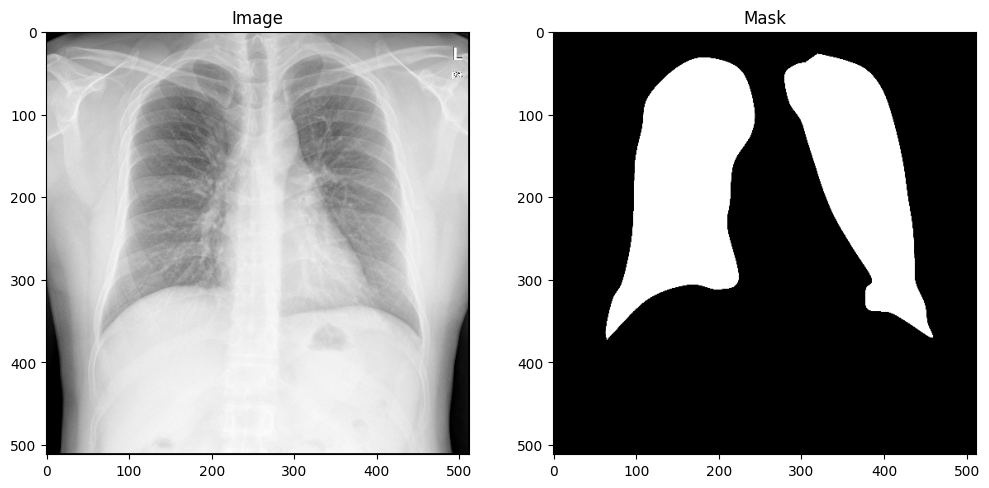

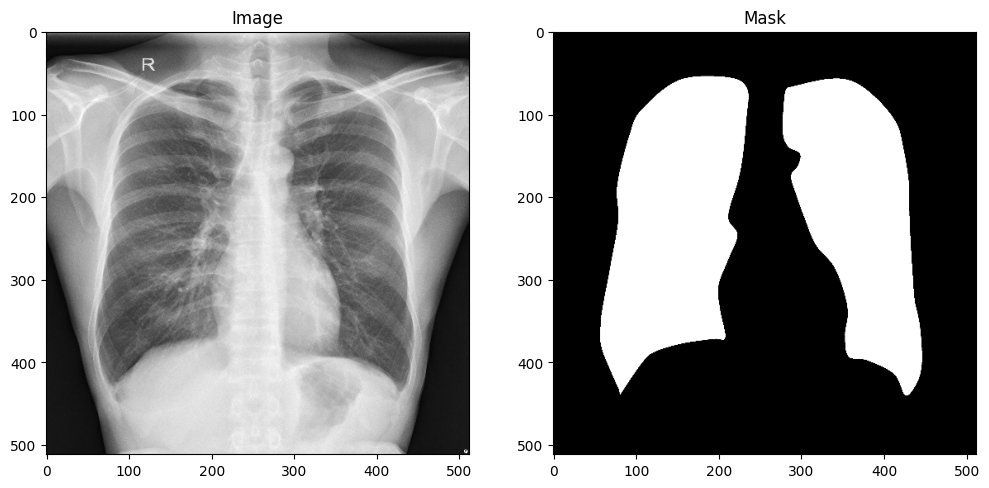

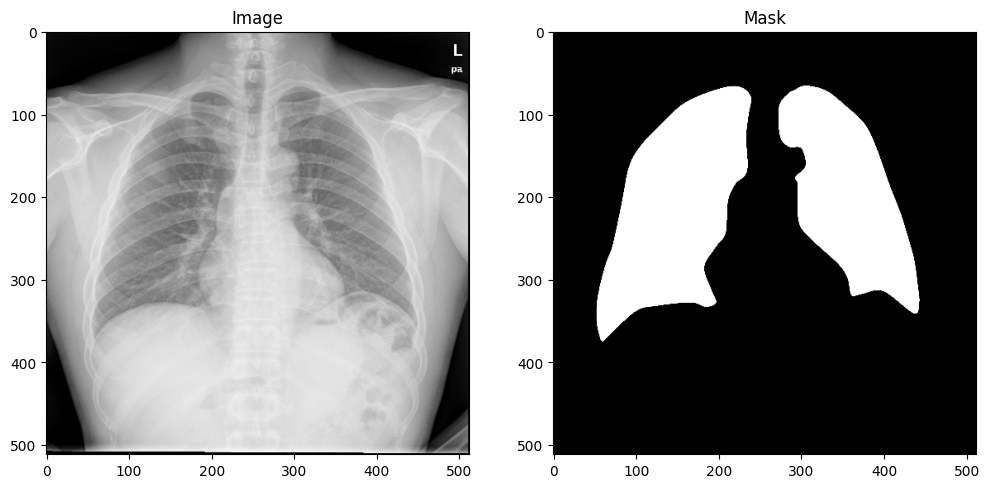

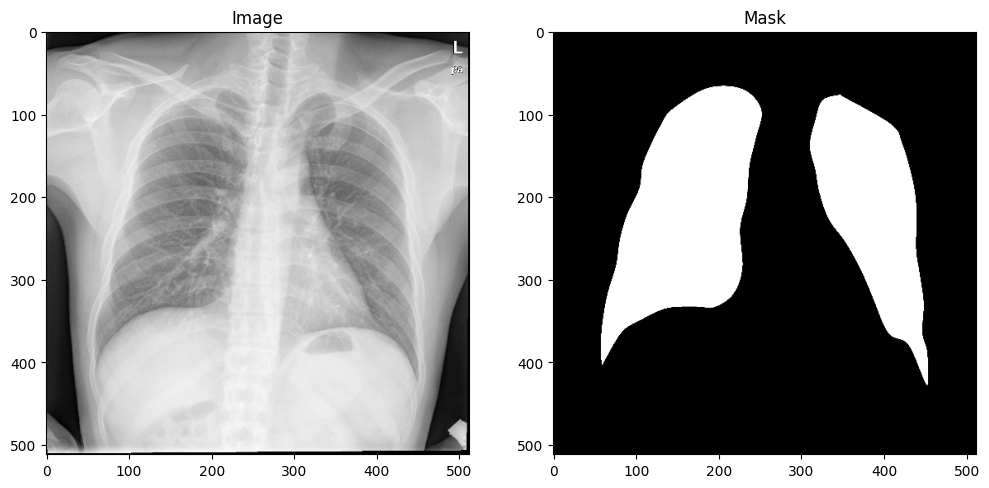

Testing Data Samples


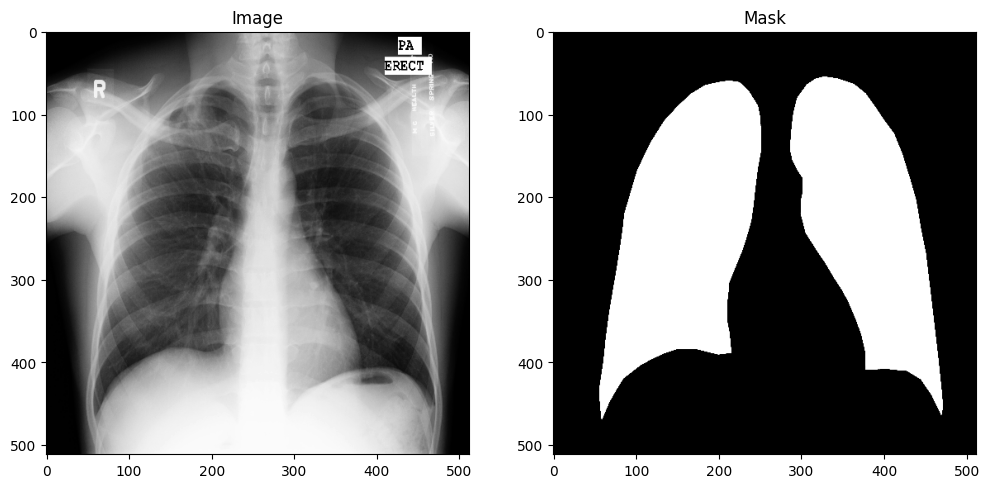

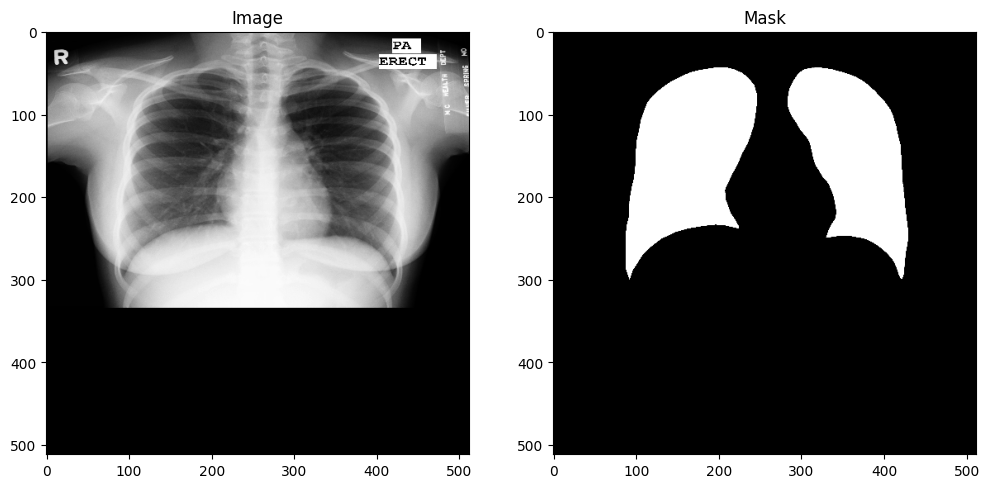

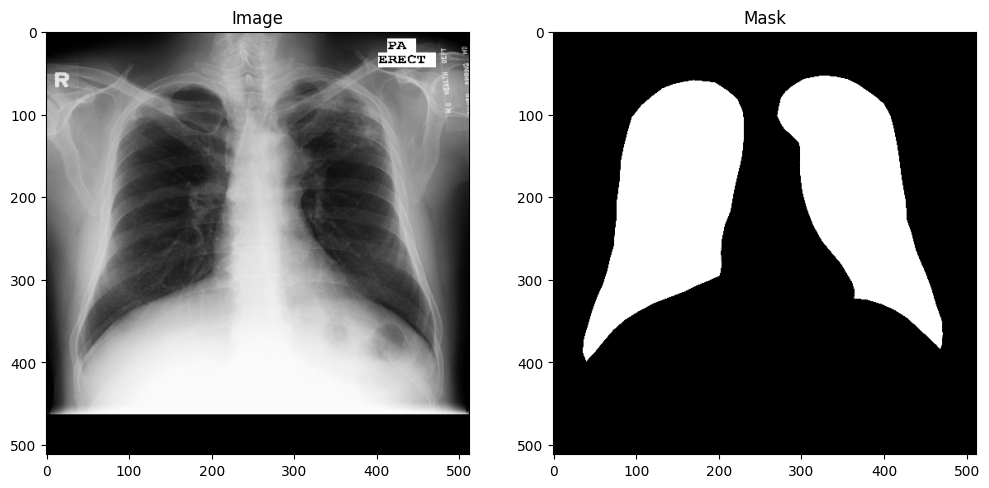

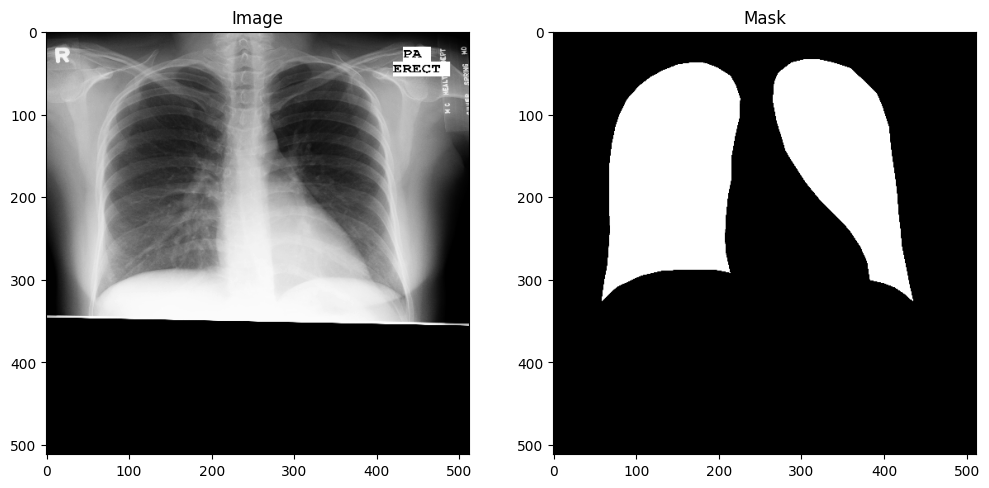

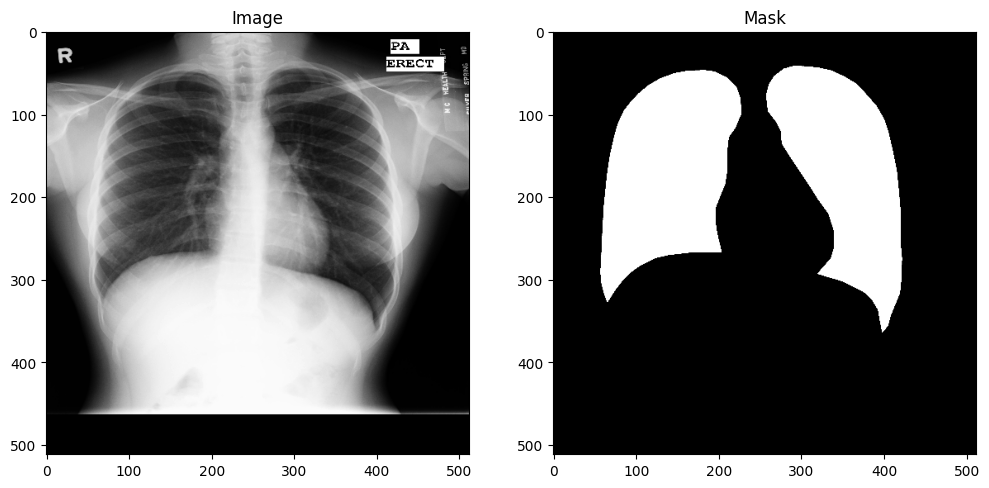

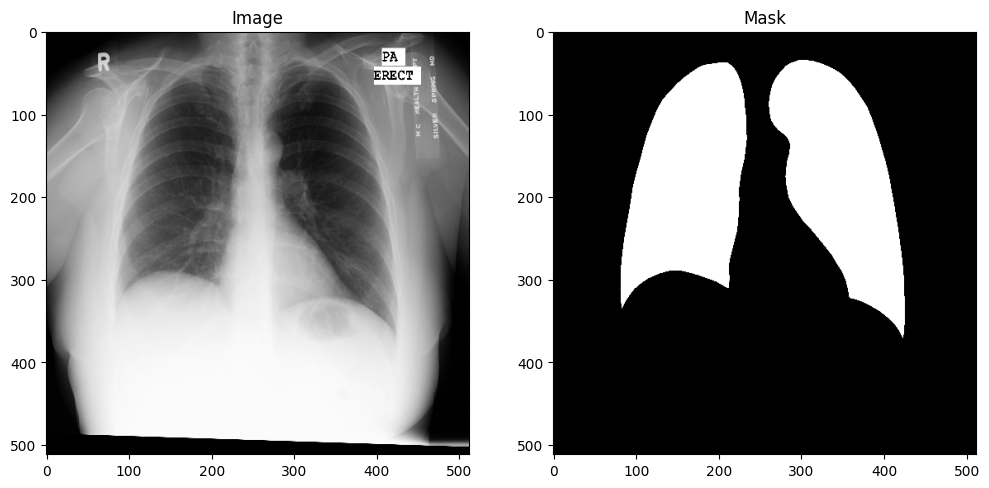

In [ ]:
# Display the samples
print("Training Data Samples")
display_data(train_data, train_masks)
print("Testing Data Samples")
display_data(test_data, test_masks)

In [ ]:
# Preprocess the data for the model
train_data = np.array(train_data).reshape(len(train_data), 512, 512, 1)
train_masks = np.array(train_masks).reshape(len(train_masks), 512, 512, 1)
test_data = np.array(test_data).reshape(len(test_data), 512, 512, 1)
test_masks = np.array(test_masks).reshape(len(test_masks), 512, 512, 1)

In [ ]:
# Combining the datasets
all_images = np.concatenate((train_data, test_data), axis=0)
all_masks = np.concatenate((train_masks, test_masks), axis=0)

# The Model : UNet

In [ ]:
def UNetArchitecture(input_dim=(256, 256, 1)):
    inputs = Input(input_dim)

    # Contracting path
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    # Expansive path
    up1 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up2 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up3 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# Configure Training

In [ ]:
unet_model = UNetArchitecture(input_dim=(512, 512, 1))
unet_model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coefficient_loss, metrics=[dice_coefficient, 'binary_accuracy'])

callbacks = [
    ModelCheckpoint("best_weights.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True),
   ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", mode="min", patience=15)
]

In [ ]:
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 512, 512, 32)         320       ['input_3[0][0]']             
                                                                                                  
 conv2d_31 (Conv2D)          (None, 512, 512, 32)         9248      ['conv2d_30[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 256, 256, 32)         0         ['conv2d_31[0][0]']           
 g2D)                                                                                       

In [ ]:
# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split((all_images - 127.0) / 127.0, (all_masks > 127).astype(np.float32), test_size=0.1, random_state=2018)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=2018)



In [ ]:
# Model Training
history = unet_model.fit(x=X_train, y=y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: -0.3366 - dice_coefficient: 0.3366 - binary_accuracy: 0.6506
Epoch 1: val_loss improved from inf to -0.33868, saving model to best_weights.hdf5
36/36 [==============================] - 19s 367ms/step - loss: -0.3366 - dice_coefficient: 0.3366 - binary_accuracy: 0.6506 - val_loss: -0.3387 - val_dice_coefficient: 0.3387 - val_binary_accuracy: 0.6450 - lr: 1.0000e-05
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: -0.3377 - dice_coefficient: 0.3376 - binary_accuracy: 0.6533
Epoch 2: val_loss improved from -0.33868 to -0.34000, saving model to best_weights.hdf5
36/36 [==============================] - 9s 255ms/step - loss: -0.3377 - dice_coefficient: 0.3376 - binary_accuracy: 0.6533 - val_loss: -0.3400 - val_dice_coefficient: 0.3400 - val_binary_accuracy: 0.6468 - lr: 1.0000e-05
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: -0.3392 - dice_coefficient: 0.3393 - binary_accuracy: 0.65

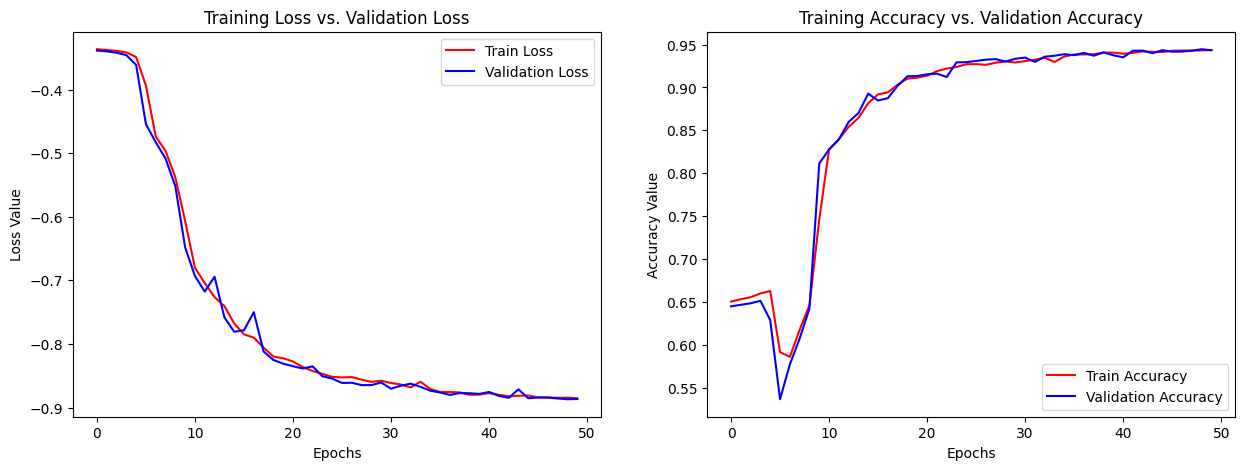

In [ ]:
# Plotting Training Results
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting the loss
loss_ax.plot(history.history['loss'], '-r', label='Train Loss')
loss_ax.plot(history.history['val_loss'], '-b', label='Validation Loss')
loss_ax.set_title('Training Loss vs. Validation Loss')
loss_ax.set_xlabel('Epochs')
loss_ax.set_ylabel('Loss Value')
loss_ax.legend()

# Plotting the accuracy
acc_ax.plot(history.history['binary_accuracy'], '-r', label='Train Accuracy')
acc_ax.plot(history.history['val_binary_accuracy'], '-b', label='Validation Accuracy')
acc_ax.set_title('Training Accuracy vs. Validation Accuracy')
acc_ax.set_xlabel('Epochs')
acc_ax.set_ylabel('Accuracy Value')
acc_ax.legend()

plt.show()

# Making Predictions

In [ ]:
# Predict on validation set
val_predictions = unet_model.predict(X_val)

3/3 [==============================] - 6s 669ms/step


In [ ]:
# Display Predicted vs Actual masks
sample_indices = np.random.choice(np.arange(X_val.shape[0]), 6)  # Randomly select 6 samples

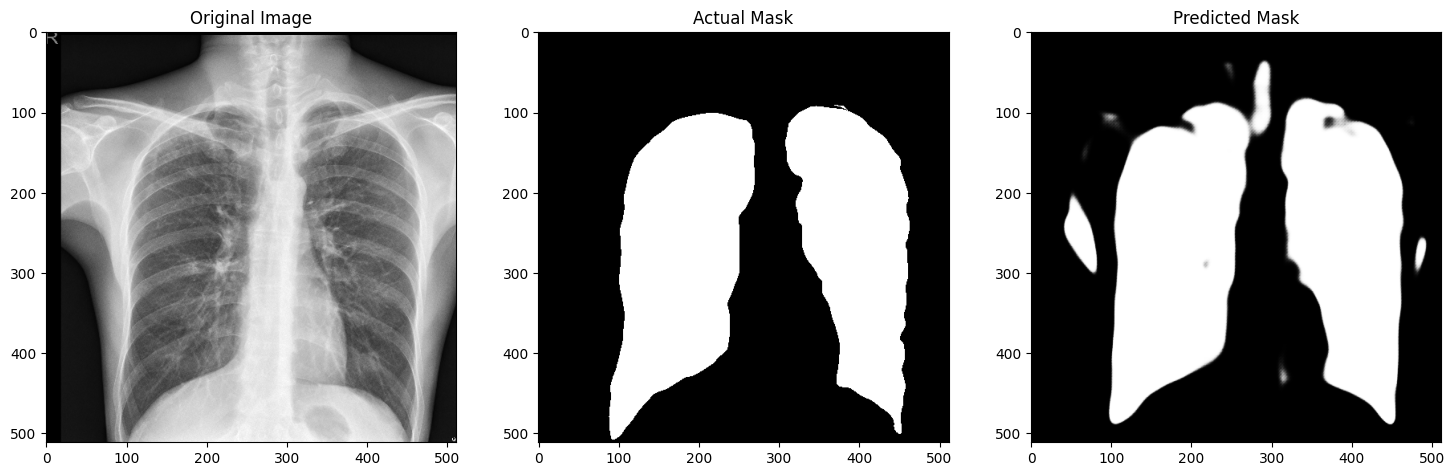

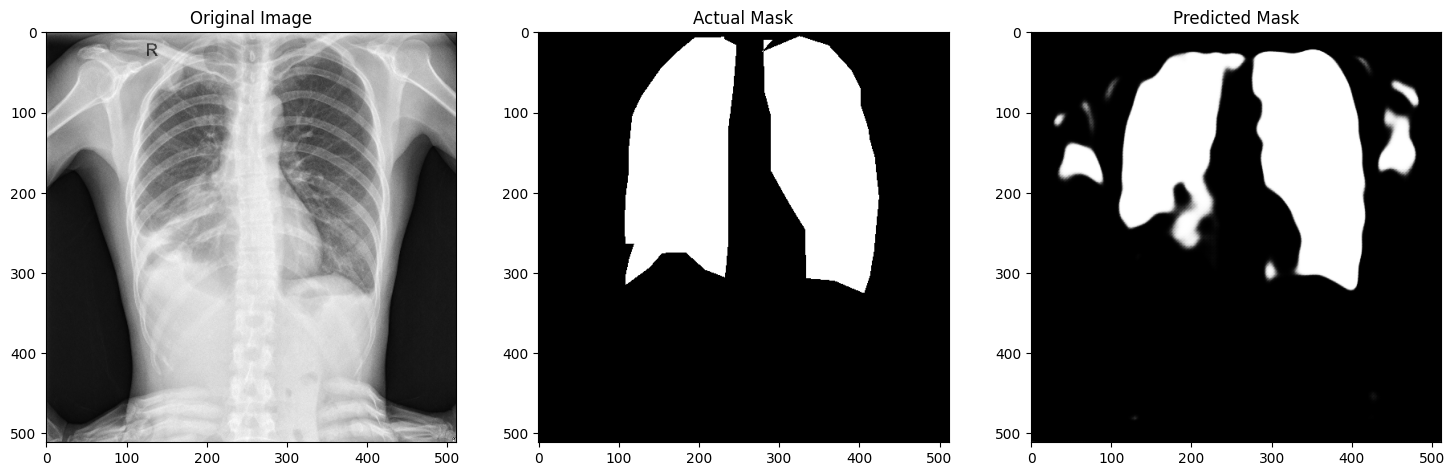

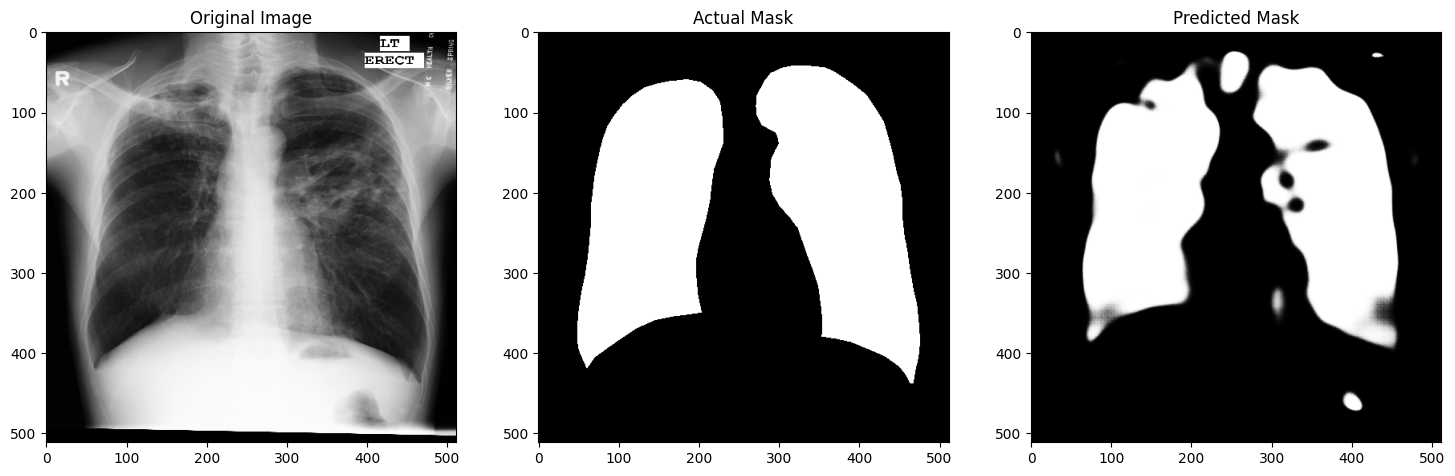

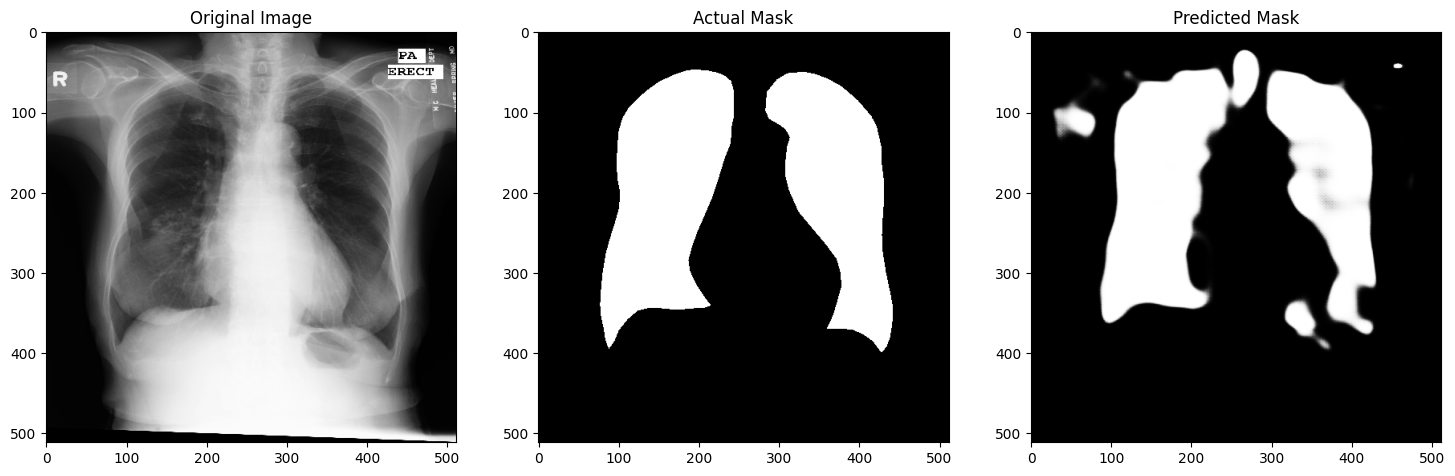

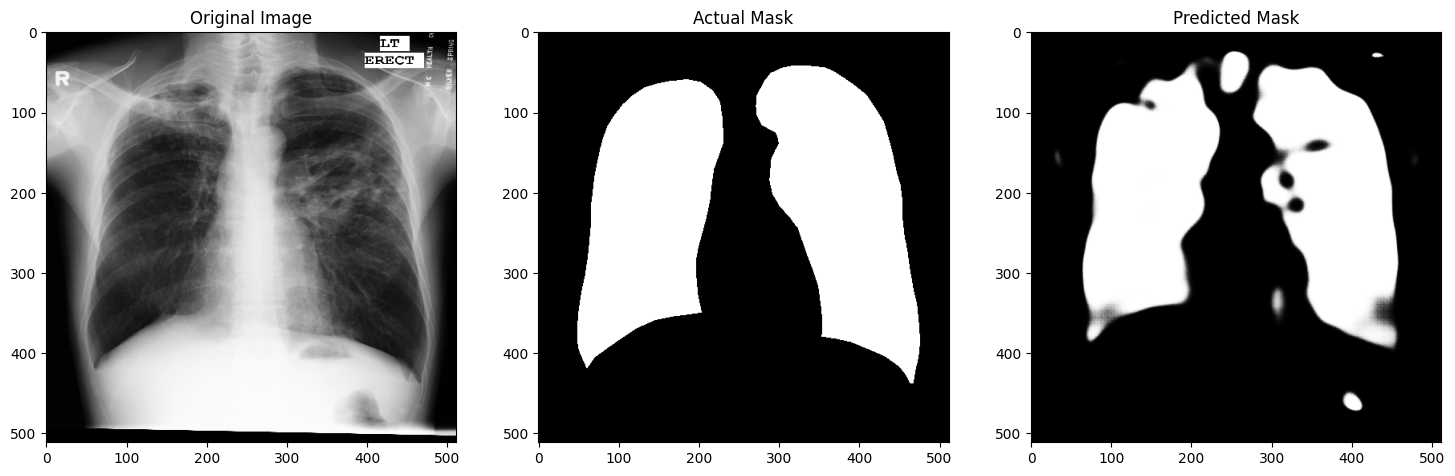

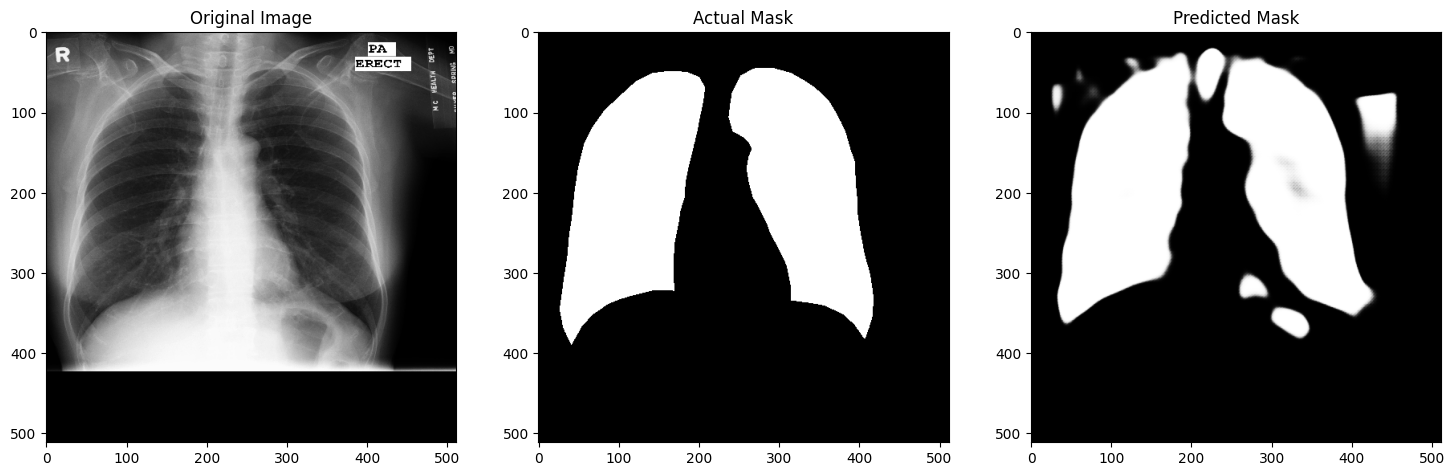

In [ ]:
for idx in sample_indices:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Display original image
    axes[0].imshow(X_val[idx].squeeze(), cmap='gray')
    axes[0].set_title('Original Image')

    # Display actual mask
    axes[1].imshow(y_val[idx].squeeze(), cmap='gray')
    axes[1].set_title('Actual Mask')

    # Display predicted mask
    axes[2].imshow(val_predictions[idx].squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')

    plt.show()

In [ ]:
# Model Evaluation
evaluation = unet_model.evaluate(X_val, y_val, verbose=0)
dice_score = evaluation[1]

print(f"Dice Coefficient on Validation Data: {dice_score:.4f}")

Dice Coefficient on Validation Data: 0.8841


In [ ]:
# Saving the U-Net model to a file
model_save_path = "/content/drive/MyDrive/Final Project/project-data/saved models/unet_model.h5"
unet_model.save(model_save_path)

model_save_path

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/Final Project/project-data/saved models/unet_model.h5'

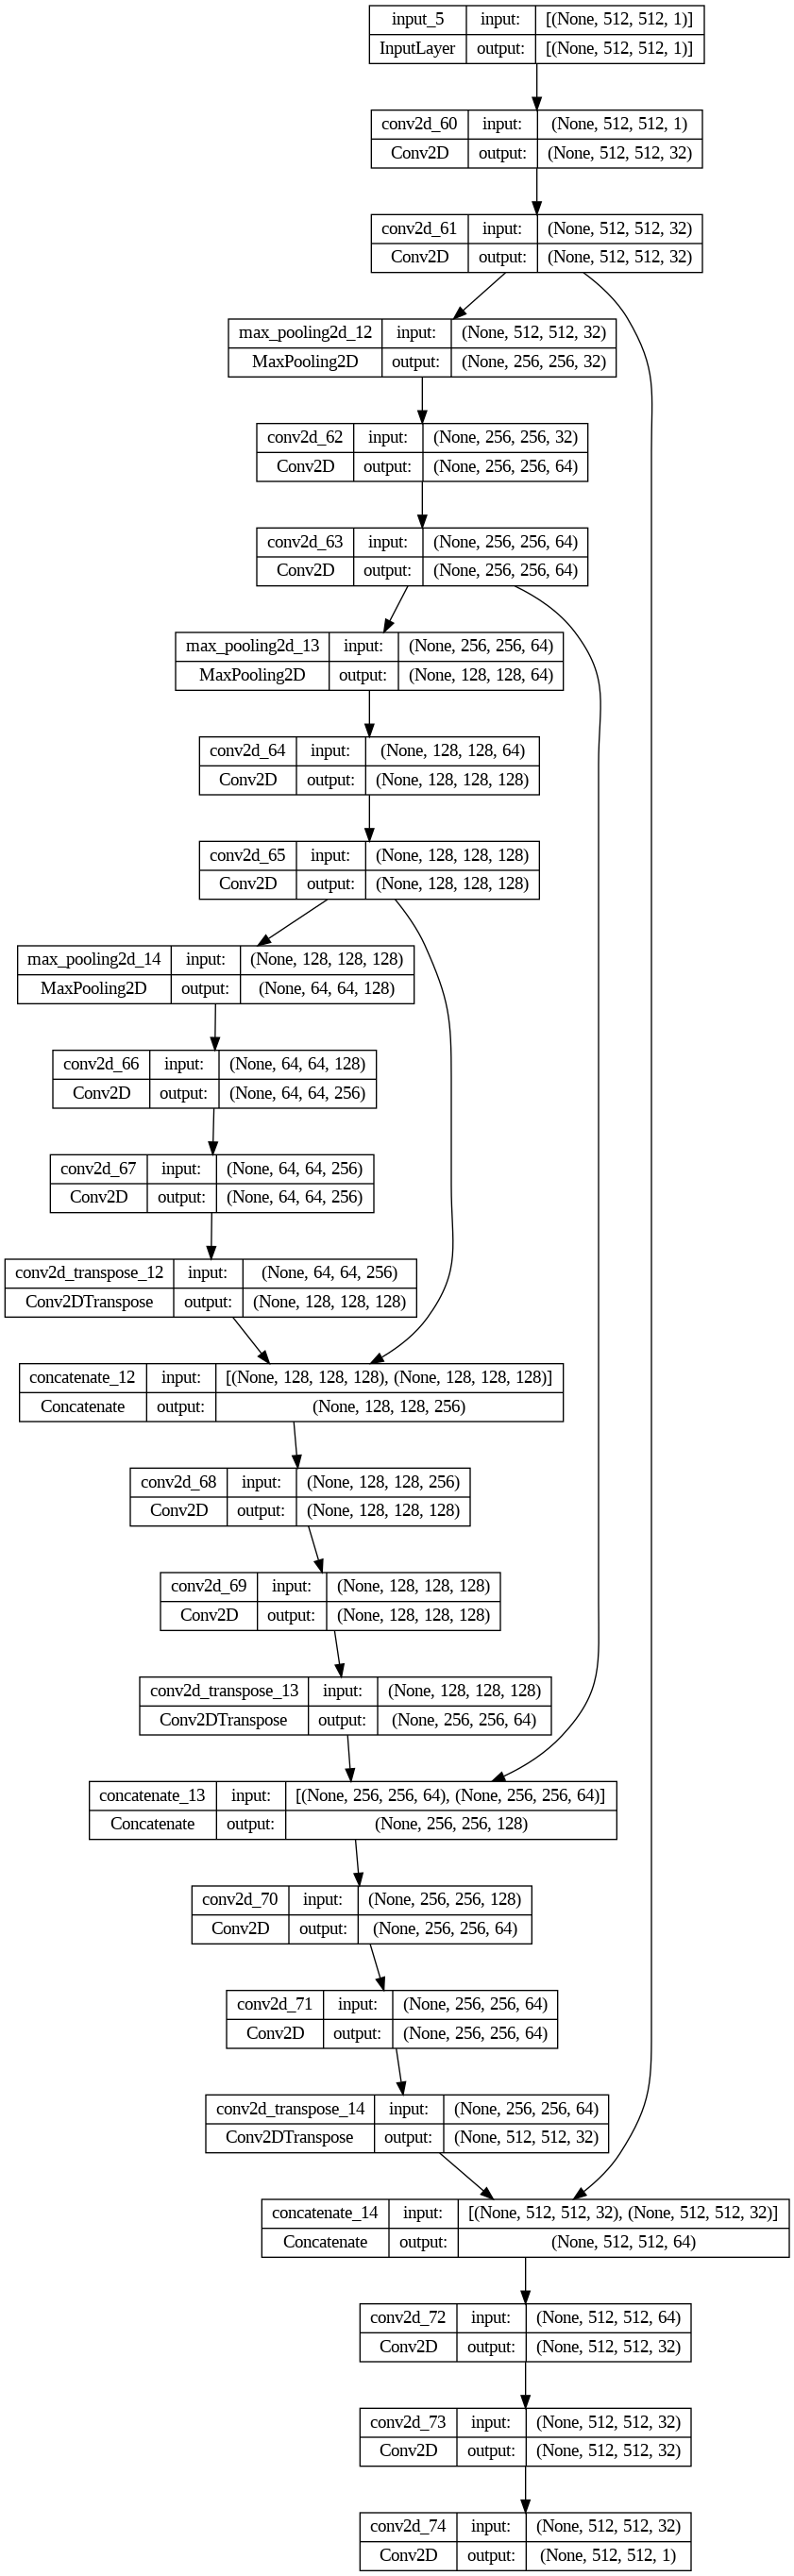

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(unet_model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)
